In [69]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

from sentinelhub import (
    SHConfig,
    MimeType,
    CRS,
    BBox,
    SentinelHubRequest,
    SentinelHubDownloadClient,
    DataCollection,
    bbox_to_dimensions,
    DownloadRequest
)

import sh_credentials
from utils import plot_image

In [70]:
#Connect to Sentinel Hub
config = SHConfig()

#Use sh_credentials in the config
config.instance_id = sh_credentials.instance_id
config.sh_client_id = sh_credentials.sh_client_id
config.sh_client_secret = sh_credentials.sh_client_secret

Found bbox of Zion:
http://bboxfinder.com/#37.161512,-113.167419,37.328589,-112.888298

In [121]:
#Define bbox
#EPSG 4326, WGS 84
zion_coords = [-113.128967,37.164474,-112.920914,37.311603]

#contrails example
zion_coords = [-113.084129,37.217211,-113.049110,37.250030]

#Define the resolution and extents of the bbox
resolution = 10
zion_bbox = BBox(bbox=zion_coords, crs=CRS.WGS84)
zion_size = bbox_to_dimensions(zion_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {zion_size} pixels")

Image shape at 10 m resolution: (319, 357) pixels


In [122]:
#Define evalscript to get imagery

evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=("2022-05-21", "2022-05-23"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox= zion_bbox,
    size= zion_size,
    config= config,
)

In [123]:
#Get the data
true_color_imgs = request_true_color.get_data()

In [124]:
print(f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}.")
print(f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}")

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (357, 319, 3)


Image type: uint8


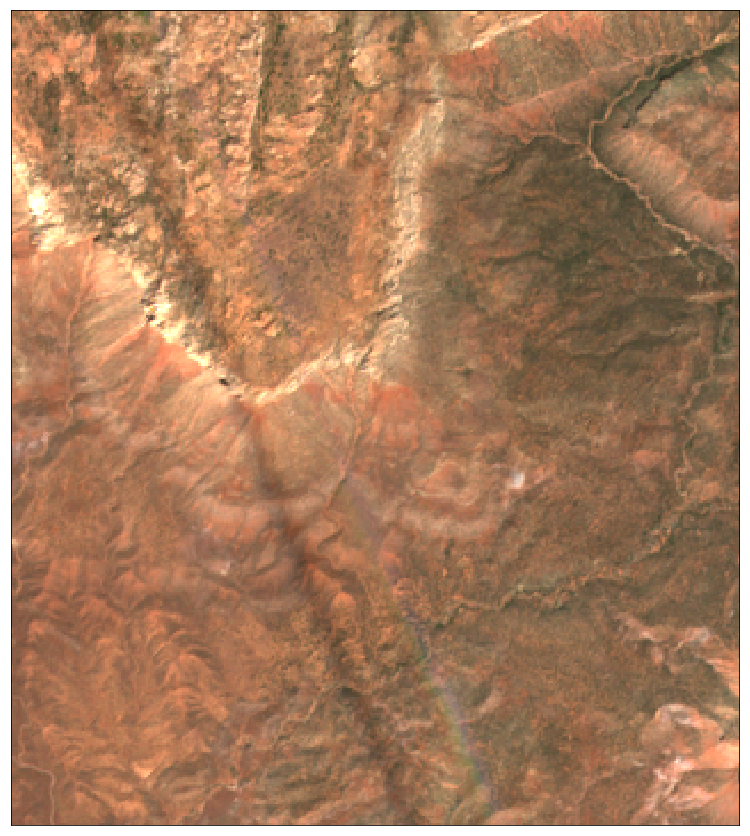

In [125]:
#Print out the image
image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

In [118]:
#Try using either the Cloud Probability or Cloud Mask layer from sentinel
evalscript_clm = """
//VERSION=3
function setup() {
  return {
    input: ["B02", "B03", "B04", "CLP"],
    output: { bands: 3 }
  }
}

function evaluatePixel(sample) {
  if (sample.CLP/255 >= 0.3) {
    return [0.75 + sample.B04, sample.B03, sample.B02]
  }
  return [3.5*sample.B04, 3.5*sample.B03, 3.5*sample.B02];
}
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_clm,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=("2022-05-21", "2022-05-23"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox= zion_bbox,
    size= zion_size,
    config=config,
)

In [119]:
# Get the masked data
data_with_cloud_mask = request_true_color.get_data()

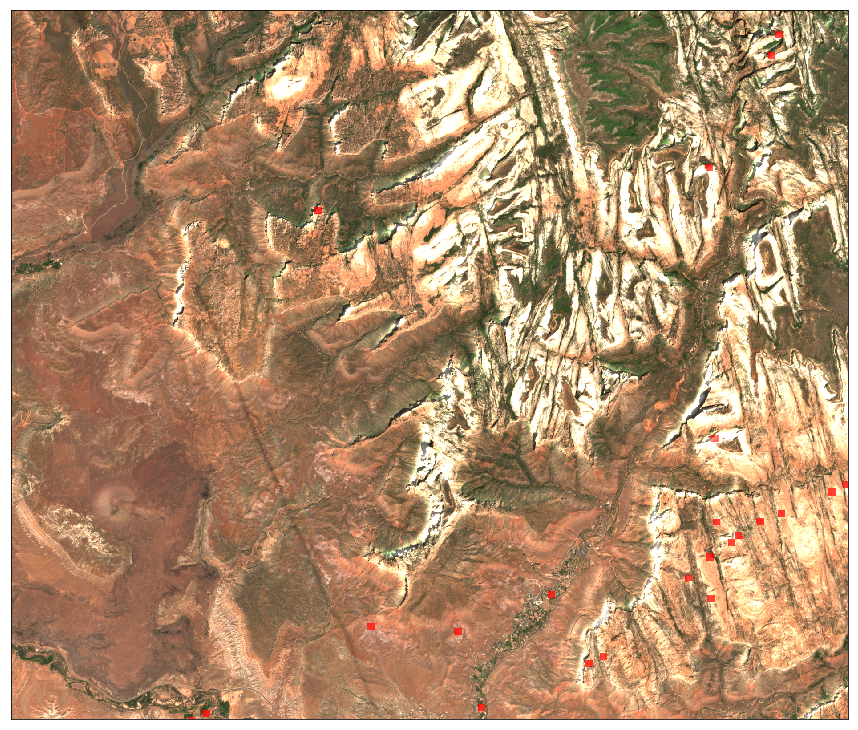

In [120]:
#Plot the image with masked pixels
#Doesn't appear the mask is catching the cirrus clouds created from the contrails.
plot_image(data_with_cloud_mask[0], factor=1 / 255)